# This preprocessing workflow is developped at 08/07/2019
* mne event coding in VD {'12.0': 5, '100.0': 2, '21.0': 8, '102.0': 4, '254.0': 11, '131.0': 6, '132.0': 7, '1.0': 1, '23.0': 10, '101.0': 3, '255.0': 12, '22.0': 9})   6-safe period   7-threat period  11-start 12-end
* one needs to notice the event coding can be different in diff files
* event recoding three-number.0(float format) code: session+state+cond
    * section 1,2
    * state: VD:1, FA:2, OP:3
    * condition safe:1, threat:2  baseline:3




In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
===============================================
Preprocessing on Enrico data using MNE and ASR
===============================================
We firstly define subject dictionary as well as state list, reject dict, then we import eeglab format 
Raw data with MNE package. We apply:
1) a notch filter to remove powerline artifact (50 Hz)
2) a 1Hz-100Hz band-pass filter
====> output = subj0*number*_*state*_filt_raw.fif  
Then concatenate the data of the same session
3) ASR and ICA fitting: This is a parallel process of preprocessing, 
    the goal is to store two sets of ica component images and generate an exclude dict from that: 
        3)do epochs in order to autoreject bad epochs and observe rejection report ===> output: cleaned epochs
        3)ICA fit and save the ICA components to reject - this is done by using function ica_component_selection()
        ====> output = fif file that save ica object and a rejecting component dict


Note: version not fullfill custer-run requirement

Suggestions:
1) decide infomation storage format
2) 

Updated on July 2019

@author: Gansheng TAN aegean0045@outlook.com    based on Manu's codes
"""

##############################################################  Set-up header ###########################################
import mne
import importlib
import numpy as np
import numpy.matlib
from mne.report import Report
from autoreject import AutoReject
from autoreject import compute_thresholds
from autoreject import get_rejection_threshold 
import matplotlib.pyplot as plt  # noqa
import matplotlib.patches as patches  # noqa
from autoreject import set_matplotlib_defaults  # noqa
from Autoreject_report_plot import Autoreject_report_plot #Gansheng
from utils_ASR import *
from scipy.linalg import toeplitz
from scipy import signal
from utils_preProcessingWorkflowJuly05 import *

%matplotlib qt
mne.set_log_level('WARNING')

##################### OS path in INSERM computer #####################################################################
raw_data_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/'
montage_fname = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/Biosemi64_MAS_EOG.locs'
report_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/report/'
full_epochs_path = '/home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/full_epochs_data/'
########################################## Algorithme parameter ############################################
cutoff = 4
pca_n_comp = 0.98
decim = 2

########################################## Initialization parameter##########################################
subj_list = ['94']
section_list=['1','2']
#state list defines the concatenating order
# state_list = ['VD','FA','OP']
state_list = ['VD','FA','OP']
power_freq_array = [50]
reject_raw_data_section1 = {'07':['OP'],'10':['FA','VD'],'21':['VD'],'36':['OP']}
reject_raw_data_section2 = {'07':['OP'], '10':['VD'], '21':['FA','VD'],
                '22':['OP'], '57':['OP','FA'], '82':['FA','OP','VD']}

# bad channel rejection is not apllied in the preproc, bad channels will be defined by eyes later
bad_channel={'94':{'FA1':['Pz']}}
# example: bad_channel = {'94':{'FA1':['FP1','FP2'],{'VD1':['Cz']}} excluded for ICA analysis


################################ step00: cut and filter data and concatenate 3 recording in one section ############

###### set up montage
montage_biosemi=mne.channels.read_montage(montage_fname)

###### preproc for each raw file
for subj in subj_list:
    section2conctn_list=[]
    ############### single subject report ###########################
    rep = Report(image_format = 'png', subject = 'subj0'+subj)
    
    for section in section_list:
        psd_figs=[]
        psd_captions=[]
        ASR_figs=[]
        ASR_captions=[]
        ica_figs=[]
        ica_captions=[]
        autoR_figs=[]
        autoR_captions=[]
        reject_state=[]
        conctn_list = []
        conctn_anno_list=[]
#         conctn_dict = {}
        if subj in eval('reject_raw_data_section'+section).keys():
            reject_state = eval('reject_raw_data_section'+section)[subj]
            print("the rejected states of subject {} in section {} are {}".format(subj,section,reject_state))
        for state in state_list:
            if state in reject_state:
                continue
            else:
                raw_fname = raw_data_path + 'subj0'+subj+'_'+state+section+'_mast.set'
                raw = mne.io.read_raw_eeglab(raw_fname,montage_biosemi,verbose='INFO',preload=True,eog='auto')                
                events = mne.events_from_annotations(raw)
                events_coding=events[1]
                # take recording from 254 start of recording to 255 end of recording
                events=np.asarray(events[0])
                events_code_start = events_coding['254.0']
                events_code_end = events_coding['255.0']
                start = events[events[:,2]==events_code_start][0][0]
                stop = events[events[:,2]==events_code_end][0][0]
                raw_cut_filt = raw.copy()
                raw_cut_filt.crop(tmin = start/raw.info['sfreq'], tmax = stop/raw.info['sfreq'])
                raw_cut_filt.notch_filter(freqs=power_freq_array)
                raw_cut_filt.filter(l_freq=1,h_freq=100)
                
                psd_figs.append(raw_cut_filt.plot_psd())
                psd_captions.append('subject '+subj+"'s "+'psd plot after cut and filtering in section' 
                                    +section+ ' during '+state+' state')
                
                ############ annotation engineering ################
                index_dlt=0
                for i in range(raw_cut_filt.annotations.__len__()):
                    if (raw_cut_filt.annotations.__getitem__(i-index_dlt)['description']) not in ['131.0','132.0','255.0']:
                        raw_cut_filt.annotations.delete(i-index_dlt)
                        index_dlt+=1                       
                    else: 
                        continue
                mne_annotation_recode_by_adding(section=section,state=state,annotations=raw_cut_filt.annotations)

                conctn_anno_list.append(raw_cut_filt.annotations)
                conctn_list.append(raw_cut_filt)

################### Concatenation process #################################""
        full_array = conctn_list[0]._data
        full_info = conctn_list[0].info
        del conctn_list[0]
        for raw2conctn in conctn_list:
            full_array = np.concatenate((full_array,raw2conctn._data),axis=1)
        raw_full = mne.io.RawArray(full_array,info = full_info)
        full_annotation = conctn_anno_list[0]
        del conctn_anno_list[0]
        for annos2conctn in conctn_anno_list:
            mne_annotation_postpone (pptime=full_annotation.__getitem__(full_annotation.__len__()-1)['onset'], 
                                         annotations=annos2conctn)
            full_annotation = full_annotation.__add__(annos2conctn)

        raw_full.set_annotations(full_annotation)
#         raw_full.plot(scalings=100e-6)
        
###########raw_full now is for one section 
        
        ############### step01: epochs engineering - calibration-epochs-ASR #################################
        rawCalibAsr = raw_full.copy()
        rawCalibAsr = rawCalibAsr.crop(tmin=10,tmax=150)
        rawCalibAsr_noYW = rawCalibAsr.copy()
        rawCalibAsr._data,iirstate = YW_filter(rawCalibAsr._data, rawCalibAsr.info['sfreq'],None)
        rawVEOG= rawCalibAsr.copy()
        rawVEOG = rawVEOG.pick_channels(['VEOG'])
        VEOG_data = np.squeeze(rawVEOG.get_data())
        peak_locs, peak_eeg = mne.preprocessing.peak_finder(VEOG_data, thresh = 100e-6)
        lengthblink = 0.5*rawCalibAsr.info['sfreq']
        startremoveblink = peak_locs-(lengthblink/2)
        stopremoveblink = peak_locs+(lengthblink/2)
        NbsampCalibAsrWindow = len(VEOG_data)
        startremoveblink = np.abs((startremoveblink>0)*startremoveblink)
        stopremoveblink =  (stopremoveblink>NbsampCalibAsrWindow-1)*NbsampCalibAsrWindow + (stopremoveblink<NbsampCalibAsrWindow-1)*stopremoveblink
        Mask=np.zeros(NbsampCalibAsrWindow)
        for ix2remove in range(len(startremoveblink)):
            Mask[int(startremoveblink[ix2remove]):int(stopremoveblink[ix2remove])]=1
        rawCalibAsr_noYW.pick_types(eeg=True)
        rawdata_noblink = np.delete(rawCalibAsr_noYW.get_data(),np.where(Mask),axis=1)
        SignalCalib=np.delete(rawdata_noblink,np.where(np.abs(rawdata_noblink)>50e-6)[1],axis=1)
        ref_maxbadchannels = 0.2
        ref_tolerances = [-3.5,5.5]
        ref_wndlen = 1
        SignalClean,sample_mask = clean_windows(SignalCalib,rawCalibAsr.info['sfreq'],ref_maxbadchannels,ref_tolerances,ref_wndlen)
        SignalClean_raw = mne.io.RawArray(SignalClean,rawCalibAsr_noYW.info)
        ASR_figs.append(SignalClean_raw.plot(scalings = 100e-6,n_channels=64,duration = 10))
        ASR_captions.append('SignalClean plot same scaling as raw 100e-6')
        srate = rawCalibAsr.info['sfreq']
        cutoff = 4
        asr_state = asr_calibrate(SignalClean,srate,cutoff)
        raw4detect = raw_full.copy()
        raw4detect.pick_types(eeg=True)
        raw_full_eeg=raw_full.copy()
        raw_full_eeg.pick_types(eeg=True)
        raw_full_eog=raw_full.copy()
        raw_full_eog.pick_types(eog=True)
        raw4detect._data,iirstate = YW_filter(raw4detect._data,raw4detect.info['sfreq'],None)
        

        events = mne.events_from_annotations(raw_full)
        for i in range(len(events[0][:,2])):
            events[0][i][2]=int(float(dict_getValue(events[1],events[0][i][2])))

        for key in events[1].keys():
            events[1][key] = int(float(key))
            
        events_time_description = events[0]   
        i=0
        while i <len(events_time_description[:,2]):
            if events_time_description[i][2]==255:
                events_time_description=np.delete(events_time_description,i,0)
            else:
                i+=1
        events_dict=events[1]
        events_dict=removeItem_from_dict(events_dict,'255.0')

        sfreq=raw_full.info['sfreq']   
        i=0
        overflow=False
     
        while overflow==False:
            if events_time_description[i,0]+sfreq*2>=events_time_description[-1][0]:
                overflow=True
            elif events_time_description[i+1,0]-events_time_description[i,0]>sfreq*2:
                events_time_description=np.insert(events_time_description,i+1,[sfreq*2+events_time_description[i,0],0,events_time_description[i,2]],axis=0)
                i+=1
            else:
                i+=1
        
    
        events=(events_time_description,events_dict)

        epochs4detect=mne.Epochs(raw4detect,events=events[0],event_id = events[1],tmin=0, tmax=2,preload=True)
        epochs_full=mne.Epochs(raw_full_eeg,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
        epochs_eog_raw_filt = mne.Epochs(raw_full_eog,events=events[0], event_id = events[1],tmin=0, tmax=2,preload=True)
        Data4detect = epochs4detect.get_data()
        Data2correct = epochs_full.get_data()
        DataClean = np.zeros((Data2correct.shape))
        num_epochs2correct = 0
        num_epochscorrected = 0
        for i_epoch in range(Data2correct.shape[0]):
            num_epochs2correct+=1
            Epoch4detect = Data4detect[i_epoch,:,:] 
            Epoch2corr = Data2correct[i_epoch,:,:]    
            DataClean[i_epoch,:,:],reconstruct = asr_process_on_epoch(Epoch2corr,Epoch4detect,asr_state)
            
            if reconstruct ==True:
                num_epochscorrected +=1
        print('ASR correcting rate is {}'.format(num_epochscorrected/num_epochs2correct))
        ASR_figs.append(plt.figure())
        ASR_captions.append('ASR correcting rate is '+str(num_epochscorrected/num_epochs2correct))
        
        epochs_ASR_clean =   mne.EpochsArray(DataClean,info=epochs_full.info,events=events[0],event_id = events[1])
        epochs_ASR_clean.add_channels([epochs_eog_raw_filt])
#         epochs_ASR_clean.plot(scalings=100e-6,n_epochs=5)
        
        
        ############### step02 ICA components check ##########################
        ica = mne.preprocessing.ICA(n_components=pca_n_comp, method='fastica', random_state=11, max_iter=100)
        ica.fit(epochs_ASR_clean,decim=decim)
        title = 'Sources related to %s artifacts (red)'
        eog_inds, scores = ica.find_bads_eog(epochs_ASR_clean,ch_name='VEOG')
        ica_figs.append(ica.plot_scores(scores, exclude=eog_inds, title=title % 'Veog', labels='Veog'))
        ica_captions.append('VEOG component correlation plot')

        if eog_inds ==[]:
            print("no Veog component is found")
        else:
            ica_figs.append(ica.plot_components(eog_inds, title=title % 'Veog', colorbar=True))
            ica_captions.append('VEOG component plot')


        eog_inds, scores = ica.find_bads_eog(epochs_ASR_clean,ch_name='HEOG')
        ica_figs.append(ica.plot_scores(scores, exclude=eog_inds, title=title % 'Heog', labels='Heog'))
        ica_captions.append('HEOG component correlation plot')
        #ica.plot_sources(epochs.average(), exclude=eog_inds, title=title % 'Veog')
        if eog_inds ==[]:
            print("no Heog component is found")
        else:
            ica_figs.append(ica.plot_components(eog_inds, title=title % 'Heog', colorbar=True))
            ica_captions.append('HEOG component correlation plot')
        
        for i in range(len(ica.plot_components(inst=epochs_ASR_clean))):
            ica_figs.append(ica.plot_components(inst=epochs_ASR_clean,show=False)[i])
            ica_captions.append('ica_components figure'+str(i))
        ica_figs.append(ica.get_sources(epochs_ASR_clean).plot(picks='all'))
        ica_captions.append('ica source plot')
        
        ################### step03 AutoRejection ##################################
        picks = mne.pick_types(epochs_ASR_clean.info, meg=False, eeg=True, stim=False,
                       eog=False)
        ar = AutoReject(picks=picks,random_state= 11,verbose='tqdm')
        ar=ar.fit(epochs_ASR_clean)
        
        picks = mne.pick_types(epochs_ASR_clean.info, meg=False, eeg=True, stim=False,
               eog=False)
        ar = AutoReject(picks=picks,random_state= 11,verbose='tqdm')
        ar=ar.fit(epochs_ASR_clean)
        epochs_autorejected, reject_log = ar.transform(epochs_ASR_clean, return_log=True)
        autoR_figs.append(epochs_autorejected.plot_drop_log())
        autoR_captions.append('autorejecting rate')
        autoR_figs.append(reject_log.plot_epochs(epochs_ASR_clean,scalings=100e-6))
        autoR_captions.append('a glimpse of autorejecting epochs')
        
        threshes = ar.threshes_
        set_matplotlib_defaults(plt)
        unit = r'uV'
        scaling = 1e6

        thres_hist=plt.figure(figsize=(6, 5))
        plt.tick_params(axis='x', which='both', bottom='off', top='off')
        plt.tick_params(axis='y', which='both', left='off', right='off')

        plt.hist(scaling * np.array(list(threshes.values())), 30,
                 color='g', alpha=0.4)
        plt.xlabel('Threshold (%s)' % unit)
        plt.ylabel('Number of sensors')
        plt.tight_layout()
        autoR_figs.append(thres_hist)
        autoR_captions.append('threshold histogram')
        
        rep.add_figs_to_section(figs=psd_figs, captions=psd_captions, section = 'section'+section+'spectral plot', 
                                image_format = 'svg')
        rep.add_figs_to_section(figs=ASR_figs, captions=ASR_captions, section = 'section'+section+'ASR plot', 
                                image_format = 'svg')
        rep.add_figs_to_section(figs=ica_figs, captions=ica_captions, section = 'section'+section+'ica plot', 
                                image_format = 'svg')
        rep.add_figs_to_section(figs=autoR_figs, captions=autoR_captions, section = 'section'+section+
                                'autoRejection plot', image_format = 'svg')
        
        section2conctn_list.append(epochs_autorejected)
        plt.close('all')
    full_epochs_fname = full_epochs_path + 'subj0'+subj+'full_epo.fif'
    full_epochs_autorejected = mne.concatenate_epochs(section2conctn_list)
    full_epochs_autorejected.save(full_epochs_fname,overwrite = True)
        
    f_report = report_path + 'subj0' + subj+'.html'
    rep.save(f_report, open_browser = False, overwrite = True)

        

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_VD1_mast.fdt
Reading 0 ... 308223  =      0.000 ...   601.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

/home/gansheng.tan/mne/local/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


no Heog component is found
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 64/64 [11:13<00:00, 10.28s/it]


Repairing epochs:   0%|          | 0/780 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 21/780 [00:00<00:03, 202.76it/s]

Repairing epochs:   5%|▌         | 41/780 [00:00<00:03, 201.70it/s]

Repairing epochs:   8%|▊         | 62/780 [00:00<00:03, 201.13it/s]

Repairing epochs:  11%|█         | 83/780 [00:00<00:03, 201.45it/s]

Repairing epochs:  13%|█▎        | 104/780 [00:00<00:03, 201.68it/s]

Repairing epochs:  16%|█▌        | 125/780 [00:00<00:03, 201.54it/s]

Repairing epochs:  19%|█▊        | 145/780 [00:00<00:03, 201.05it/s]

Repairing epochs:  21%|██        | 164/780 [00:00<00:03, 168.04it/s]

Repairing epochs:  23%|██▎       | 181/780 [00:00<00:03, 159.77it/s]

Repairing epochs:  25%|██▌       | 197/780 [00:01<00:03, 154.81it/s]

Repairing epochs:  27%|██▋       | 213/780 [00:01<00:03, 150.90it/s]

Repairing epochs:  29%|██▉       | 229/780 [00:01<00:03, 148.62it/s]

Repairing epochs:  31%|███▏  

Repairing epochs:  33%|███▎      | 255/780 [00:07<00:14, 36.22it/s]

Repairing epochs:  33%|███▎      | 259/780 [00:07<00:15, 34.29it/s]

Repairing epochs:  34%|███▎      | 263/780 [00:07<00:14, 34.49it/s]

Repairing epochs:  34%|███▍      | 267/780 [00:07<00:14, 35.31it/s]

Repairing epochs:  35%|███▍      | 271/780 [00:07<00:14, 36.01it/s]

Repairing epochs:  35%|███▌      | 275/780 [00:07<00:13, 36.48it/s]

Repairing epochs:  36%|███▌      | 279/780 [00:08<00:13, 36.72it/s]

Repairing epochs:  36%|███▋      | 283/780 [00:08<00:13, 36.96it/s]

Repairing epochs:  37%|███▋      | 287/780 [00:08<00:13, 37.49it/s]

Repairing epochs:  37%|███▋      | 291/780 [00:08<00:13, 37.58it/s]

Repairing epochs:  38%|███▊      | 295/780 [00:08<00:12, 37.66it/s]

Repairing epochs:  38%|███▊      | 299/780 [00:08<00:12, 37.66it/s]

Repairing epochs:  39%|███▉      | 303/780 [00:08<00:12, 37.18it/s]

Repairing epochs:  39%|███▉      | 307/780 [00:08<00:12, 36.44it/s]

Repairing epochs:  40%|████      |

Repairing epochs:  89%|████████▉ | 694/780 [00:19<00:02, 38.11it/s]

Repairing epochs:  89%|████████▉ | 698/780 [00:19<00:02, 38.00it/s]

Repairing epochs:  90%|█████████ | 702/780 [00:20<00:02, 37.82it/s]

Repairing epochs:  91%|█████████ | 706/780 [00:20<00:01, 38.15it/s]

Repairing epochs:  91%|█████████ | 710/780 [00:20<00:04, 14.71it/s]

Repairing epochs:  92%|█████████▏| 714/780 [00:20<00:03, 17.94it/s]

Repairing epochs:  92%|█████████▏| 718/780 [00:20<00:02, 21.32it/s]

Repairing epochs:  93%|█████████▎| 722/780 [00:21<00:02, 24.54it/s]

Repairing epochs:  93%|█████████▎| 726/780 [00:21<00:01, 27.61it/s]

Repairing epochs:  94%|█████████▎| 730/780 [00:21<00:01, 30.18it/s]

Repairing epochs:  94%|█████████▍| 734/780 [00:21<00:01, 32.16it/s]

Repairing epochs:  95%|█████████▍| 738/780 [00:21<00:01, 33.58it/s]

Repairing epochs:  95%|█████████▌| 742/780 [00:21<00:01, 34.86it/s]

Repairing epochs:  96%|█████████▌| 746/780 [00:21<00:00, 35.60it/s]

Repairing epochs:  96%|█████████▌|

Repairing epochs:  39%|███▉      | 306/780 [00:08<00:12, 36.58it/s]

Repairing epochs:  40%|███▉      | 310/780 [00:08<00:12, 36.47it/s]

Repairing epochs:  40%|████      | 314/780 [00:08<00:12, 37.04it/s]

Repairing epochs:  41%|████      | 318/780 [00:08<00:12, 36.64it/s]

Repairing epochs:  41%|████▏     | 322/780 [00:08<00:12, 36.74it/s]

Repairing epochs:  42%|████▏     | 326/780 [00:08<00:12, 36.48it/s]

Repairing epochs:  42%|████▏     | 330/780 [00:08<00:12, 36.75it/s]

Repairing epochs:  43%|████▎     | 334/780 [00:09<00:12, 37.05it/s]

Repairing epochs:  43%|████▎     | 338/780 [00:09<00:11, 37.20it/s]

Repairing epochs:  44%|████▍     | 342/780 [00:09<00:11, 37.04it/s]

Repairing epochs:  44%|████▍     | 346/780 [00:09<00:11, 37.36it/s]

Repairing epochs:  45%|████▍     | 350/780 [00:09<00:11, 37.67it/s]

Repairing epochs:  45%|████▌     | 354/780 [00:09<00:11, 37.09it/s]

Repairing epochs:  46%|████▌     | 358/780 [00:09<00:11, 36.85it/s]

Repairing epochs:  46%|████▋     |

Repairing epochs:  95%|█████████▌| 744/780 [00:20<00:00, 37.66it/s]

Repairing epochs:  96%|█████████▌| 748/780 [00:20<00:00, 37.35it/s]

Repairing epochs:  96%|█████████▋| 752/780 [00:20<00:00, 37.54it/s]

Repairing epochs:  97%|█████████▋| 756/780 [00:20<00:00, 37.33it/s]

Repairing epochs:  97%|█████████▋| 760/780 [00:20<00:00, 37.14it/s]

Repairing epochs:  98%|█████████▊| 764/780 [00:20<00:00, 37.40it/s]

Repairing epochs:  98%|█████████▊| 768/780 [00:20<00:00, 37.12it/s]

Repairing epochs:  99%|█████████▉| 772/780 [00:20<00:00, 37.14it/s]

Repairing epochs:  99%|█████████▉| 776/780 [00:21<00:00, 37.10it/s]

Repairing epochs: 100%|██████████| 780/780 [00:21<00:00, 36.63it/s]


Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:09<01:24,  9.38s/it]


Fold:  20%|██        | 2/10 [00:18<01:14,  9.30s/it]


Fold:  30%|███       | 3/10 [00:27<01:04,  9.23s/it]


Fold:  40%|████      | 4/10 [00:36<00:54,  9.14s/it]


Fold:  50%|█████     | 5/10 [00:45<00:45, 

Repairing epochs:  74%|███████▍  | 577/780 [00:11<00:04, 45.25it/s]

Repairing epochs:  75%|███████▍  | 582/780 [00:11<00:04, 45.84it/s]

Repairing epochs:  75%|███████▌  | 588/780 [00:11<00:04, 46.60it/s]

Repairing epochs:  76%|███████▌  | 593/780 [00:11<00:04, 43.50it/s]

Repairing epochs:  77%|███████▋  | 598/780 [00:11<00:04, 42.44it/s]

Repairing epochs:  77%|███████▋  | 603/780 [00:12<00:04, 40.86it/s]

Repairing epochs:  78%|███████▊  | 608/780 [00:12<00:04, 39.33it/s]

Repairing epochs:  78%|███████▊  | 612/780 [00:12<00:04, 38.88it/s]

Repairing epochs:  79%|███████▉  | 616/780 [00:12<00:04, 38.64it/s]

Repairing epochs:  79%|███████▉  | 620/780 [00:12<00:04, 37.81it/s]

Repairing epochs:  80%|████████  | 624/780 [00:12<00:04, 37.88it/s]

Repairing epochs:  81%|████████  | 629/780 [00:12<00:03, 40.48it/s]

Repairing epochs:  81%|████████▏ | 634/780 [00:12<00:03, 39.85it/s]

Repairing epochs:  82%|████████▏ | 639/780 [00:13<00:03, 39.38it/s]

Repairing epochs:  82%|████████▏ |





Estimated consensus=0.70 and n_interpolate=4
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 64/64 [11:11<00:00, 10.44s/it]


Repairing epochs:   0%|          | 0/780 [00:00<?, ?it/s]

Repairing epochs:   2%|▏         | 13/780 [00:00<00:06, 124.79it/s]

Repairing epochs:   3%|▎         | 22/780 [00:00<00:06, 111.44it/s]

Repairing epochs:   4%|▍         | 35/780 [00:00<00:06, 114.66it/s]

Repairing epochs:   7%|▋         | 52/780 [00:00<00:05, 126.58it/s]

Repairing epochs:   9%|▉         | 72/780 [00:00<00:05, 140.93it/s]

Repairing epochs:  12%|█▏        | 92/780 [00:00<00:04, 153.18it/s]

Repairing epochs:  14%|█▍        | 112/780 [00:00<00:04, 163.24it/s]

Repairing epochs:  17%|█▋        | 132/780 [00:00<00:03, 171.46it/s]

Repairing epochs:  19%|█▉        | 152/780 [00:00<00:03, 177.98it/s]

Repairing epochs:  22%|██▏       | 172/780 [00:01<00:03, 183.31it/s]

Repairing epochs:  25%|██▍       | 192/780 [00:01<00:03, 187.08it/s]

Repairing epochs:  27%|██▋       | 212/780 [00:01<00:02, 189.97it/s]

Repairing epochs:  30%|██▉     

Repairing epochs:  33%|███▎      | 256/780 [00:07<00:14, 35.28it/s]

Repairing epochs:  33%|███▎      | 260/780 [00:07<00:15, 34.51it/s]

Repairing epochs:  34%|███▍      | 264/780 [00:07<00:14, 34.76it/s]

Repairing epochs:  34%|███▍      | 268/780 [00:07<00:14, 34.98it/s]

Repairing epochs:  35%|███▍      | 272/780 [00:07<00:14, 34.82it/s]

Repairing epochs:  35%|███▌      | 276/780 [00:07<00:14, 34.87it/s]

Repairing epochs:  36%|███▌      | 280/780 [00:07<00:14, 34.72it/s]

Repairing epochs:  36%|███▋      | 284/780 [00:07<00:14, 35.01it/s]

Repairing epochs:  37%|███▋      | 288/780 [00:07<00:14, 34.91it/s]

Repairing epochs:  37%|███▋      | 292/780 [00:08<00:14, 34.81it/s]

Repairing epochs:  38%|███▊      | 296/780 [00:08<00:13, 34.93it/s]

Repairing epochs:  38%|███▊      | 300/780 [00:08<00:13, 35.13it/s]

Repairing epochs:  39%|███▉      | 304/780 [00:08<00:13, 35.25it/s]

Repairing epochs:  39%|███▉      | 308/780 [00:08<00:13, 35.54it/s]

Repairing epochs:  40%|████      |

Repairing epochs:  89%|████████▉ | 694/780 [00:19<00:02, 35.19it/s]

Repairing epochs:  89%|████████▉ | 698/780 [00:19<00:02, 35.87it/s]

Repairing epochs:  90%|█████████ | 702/780 [00:19<00:02, 35.85it/s]

Repairing epochs:  91%|█████████ | 706/780 [00:19<00:02, 36.56it/s]

Repairing epochs:  91%|█████████ | 710/780 [00:20<00:01, 37.05it/s]

Repairing epochs:  92%|█████████▏| 714/780 [00:20<00:01, 37.03it/s]

Repairing epochs:  92%|█████████▏| 718/780 [00:20<00:01, 37.12it/s]

Repairing epochs:  93%|█████████▎| 722/780 [00:20<00:01, 36.99it/s]

Repairing epochs:  93%|█████████▎| 726/780 [00:20<00:01, 37.59it/s]

Repairing epochs:  94%|█████████▎| 730/780 [00:20<00:01, 37.07it/s]

Repairing epochs:  94%|█████████▍| 734/780 [00:20<00:01, 34.57it/s]

Repairing epochs:  95%|█████████▍| 738/780 [00:20<00:01, 35.52it/s]

Repairing epochs:  95%|█████████▌| 742/780 [00:20<00:01, 36.26it/s]

Repairing epochs:  96%|█████████▌| 746/780 [00:21<00:00, 36.62it/s]

Repairing epochs:  96%|█████████▌|

Repairing epochs:  39%|███▉      | 305/780 [00:08<00:12, 37.15it/s]

Repairing epochs:  40%|███▉      | 309/780 [00:08<00:12, 37.07it/s]

Repairing epochs:  40%|████      | 313/780 [00:08<00:12, 37.28it/s]

Repairing epochs:  41%|████      | 317/780 [00:08<00:12, 37.55it/s]

Repairing epochs:  41%|████      | 321/780 [00:08<00:12, 37.40it/s]

Repairing epochs:  42%|████▏     | 325/780 [00:08<00:12, 35.83it/s]

Repairing epochs:  42%|████▏     | 329/780 [00:09<00:12, 35.14it/s]

Repairing epochs:  43%|████▎     | 333/780 [00:09<00:12, 35.27it/s]

Repairing epochs:  43%|████▎     | 337/780 [00:09<00:12, 35.46it/s]

Repairing epochs:  44%|████▎     | 341/780 [00:09<00:12, 36.03it/s]

Repairing epochs:  44%|████▍     | 345/780 [00:09<00:11, 36.48it/s]

Repairing epochs:  45%|████▍     | 349/780 [00:09<00:11, 36.96it/s]

Repairing epochs:  45%|████▌     | 353/780 [00:09<00:11, 36.90it/s]

Repairing epochs:  46%|████▌     | 357/780 [00:09<00:11, 36.98it/s]

Repairing epochs:  46%|████▋     |

Repairing epochs:  95%|█████████▌| 742/780 [00:21<00:01, 34.33it/s]

Repairing epochs:  96%|█████████▌| 746/780 [00:21<00:00, 35.41it/s]

Repairing epochs:  96%|█████████▌| 750/780 [00:21<00:00, 35.97it/s]

Repairing epochs:  97%|█████████▋| 754/780 [00:21<00:00, 36.54it/s]

Repairing epochs:  97%|█████████▋| 758/780 [00:21<00:00, 36.76it/s]

Repairing epochs:  98%|█████████▊| 762/780 [00:21<00:00, 36.67it/s]

Repairing epochs:  98%|█████████▊| 766/780 [00:21<00:00, 37.03it/s]

Repairing epochs:  99%|█████████▊| 770/780 [00:21<00:00, 36.83it/s]

Repairing epochs:  99%|█████████▉| 774/780 [00:21<00:00, 37.32it/s]

Repairing epochs: 100%|█████████▉| 778/780 [00:21<00:00, 36.97it/s]

Repairing epochs: 100%|██████████| 780/780 [00:22<00:00, 35.37it/s]


Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:09<01:25,  9.54s/it]


Fold:  20%|██        | 2/10 [00:18<01:15,  9.42s/it]


Fold:  30%|███       | 3/10 [00:27<01:05,  9.33s/it]


Fold:  40%|████      | 4/10 

Repairing epochs:  71%|███████▏  | 557/780 [00:10<00:04, 47.52it/s]

Repairing epochs:  72%|███████▏  | 562/780 [00:10<00:05, 40.94it/s]

Repairing epochs:  73%|███████▎  | 567/780 [00:11<00:05, 39.16it/s]

Repairing epochs:  73%|███████▎  | 572/780 [00:11<00:05, 40.63it/s]

Repairing epochs:  74%|███████▍  | 577/780 [00:11<00:05, 39.83it/s]

Repairing epochs:  75%|███████▍  | 582/780 [00:11<00:04, 40.35it/s]

Repairing epochs:  75%|███████▌  | 587/780 [00:11<00:04, 41.97it/s]

Repairing epochs:  76%|███████▌  | 592/780 [00:11<00:04, 40.76it/s]

Repairing epochs:  77%|███████▋  | 597/780 [00:11<00:04, 40.17it/s]

Repairing epochs:  77%|███████▋  | 602/780 [00:11<00:04, 40.28it/s]

Repairing epochs:  78%|███████▊  | 607/780 [00:12<00:04, 38.70it/s]

Repairing epochs:  78%|███████▊  | 611/780 [00:12<00:04, 38.70it/s]

Repairing epochs:  79%|███████▉  | 615/780 [00:12<00:04, 38.22it/s]

Repairing epochs:  79%|███████▉  | 619/780 [00:12<00:04, 38.04it/s]

Repairing epochs:  80%|███████▉  |





Estimated consensus=0.70 and n_interpolate=4




Repairing epochs:   0%|          | 0/780 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 3/780 [00:00<00:26, 29.01it/s]

Repairing epochs:   1%|          | 7/780 [00:00<00:26, 28.99it/s]

Repairing epochs:   1%|▏         | 11/780 [00:00<00:25, 30.08it/s]

Repairing epochs:   2%|▏         | 15/780 [00:00<00:24, 31.69it/s]

Repairing epochs:   2%|▏         | 19/780 [00:00<00:23, 31.84it/s]

Repairing epochs:   3%|▎         | 23/780 [00:00<00:23, 32.23it/s]

Repairing epochs:   3%|▎         | 27/780 [00:00<00:22, 33.63it/s]

Repairing epochs:   4%|▍         | 31/780 [00:00<00:21, 34.95it/s]

Repairing epochs:   4%|▍         | 35/780 [00:01<00:21, 35.46it/s]

Repairing epochs:   5%|▌         | 39/780 [00:01<00:20, 35.94it/s]

Repairing epochs:   6%|▌         | 43/780 [00:01<00:20, 35.13it/s]

Repairing epochs:   6%|▌         | 47/780 [00:01<00:20, 35.84it/s]

Repairing epochs:   7%|▋         | 51/780 [00:02<00:50, 14.32it/s]

Repairing epochs:   7%|▋         | 55/780 [00:02<00:41, 1

Repairing epochs:  56%|█████▌    | 435/780 [00:12<00:09, 37.41it/s]

Repairing epochs:  56%|█████▋    | 439/780 [00:12<00:09, 36.86it/s]

Repairing epochs:  57%|█████▋    | 443/780 [00:12<00:09, 36.84it/s]

Repairing epochs:  57%|█████▋    | 447/780 [00:12<00:08, 37.03it/s]

Repairing epochs:  58%|█████▊    | 451/780 [00:13<00:08, 37.06it/s]

Repairing epochs:  58%|█████▊    | 455/780 [00:13<00:08, 37.05it/s]

Repairing epochs:  59%|█████▉    | 459/780 [00:13<00:08, 36.92it/s]

Repairing epochs:  59%|█████▉    | 463/780 [00:13<00:08, 37.07it/s]

Repairing epochs:  60%|█████▉    | 467/780 [00:13<00:08, 37.50it/s]

Repairing epochs:  60%|██████    | 471/780 [00:13<00:08, 37.63it/s]

Repairing epochs:  61%|██████    | 475/780 [00:13<00:08, 37.72it/s]

Repairing epochs:  61%|██████▏   | 479/780 [00:13<00:08, 37.50it/s]

Repairing epochs:  62%|██████▏   | 483/780 [00:13<00:07, 37.14it/s]

Repairing epochs:  62%|██████▏   | 487/780 [00:14<00:07, 37.31it/s]

Repairing epochs:  63%|██████▎   |

Reading /home/gansheng.tan/process_mne/INSERM_EEG_Enrico_Proc/data_eeglab/raw_data/subj094_VD2_mast.fdt
Reading 0 ... 309247  =      0.000 ...   603.998 secs...
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

Computing thresholds ...: 100%|██████████| 64/64 [11:00<00:00, 10.17s/it]


Repairing epochs:   0%|          | 0/777 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 11/777 [00:00<00:07, 108.35it/s]

Repairing epochs:   3%|▎         | 26/777 [00:00<00:06, 116.39it/s]

Repairing epochs:   5%|▍         | 37/777 [00:00<00:06, 112.55it/s]

Repairing epochs:   7%|▋         | 52/777 [00:00<00:06, 119.96it/s]

Repairing epochs:   9%|▊         | 67/777 [00:00<00:05, 126.13it/s]

Repairing epochs:  11%|█         | 82/777 [00:00<00:05, 130.85it/s]

Repairing epochs:  12%|█▏        | 97/777 [00:00<00:05, 134.20it/s]

Repairing epochs:  14%|█▍        | 112/777 [00:00<00:04, 136.46it/s]

Repairing epochs:  16%|█▋        | 128/777 [00:00<00:04, 141.95it/s]

Repairing epochs:  19%|█▉        | 148/777 [00:01<00:04, 154.93it/s]

Repairing epochs:  21%|██        | 164/777 [00:01<00:04, 141.05it/s]

Repairing epochs:  23%|██▎       | 179/777 [00:01<00:04, 141.47it/s]

Repairing epochs:  25%|██▍      

Repairing epochs:  39%|███▊      | 301/777 [00:07<00:11, 41.59it/s]

Repairing epochs:  39%|███▉      | 306/777 [00:07<00:12, 37.84it/s]

Repairing epochs:  40%|███▉      | 310/777 [00:07<00:12, 37.79it/s]

Repairing epochs:  40%|████      | 314/777 [00:07<00:12, 37.66it/s]

Repairing epochs:  41%|████      | 318/777 [00:07<00:12, 37.08it/s]

Repairing epochs:  42%|████▏     | 323/777 [00:07<00:12, 37.77it/s]

Repairing epochs:  42%|████▏     | 328/777 [00:07<00:11, 38.22it/s]

Repairing epochs:  43%|████▎     | 333/777 [00:08<00:11, 39.44it/s]

Repairing epochs:  43%|████▎     | 337/777 [00:08<00:11, 37.50it/s]

Repairing epochs:  44%|████▍     | 341/777 [00:08<00:12, 35.79it/s]

Repairing epochs:  45%|████▍     | 346/777 [00:08<00:11, 37.34it/s]

Repairing epochs:  45%|████▌     | 350/777 [00:08<00:11, 37.58it/s]

Repairing epochs:  46%|████▌     | 354/777 [00:08<00:11, 36.41it/s]

Repairing epochs:  46%|████▌     | 358/777 [00:08<00:11, 35.85it/s]

Repairing epochs:  47%|████▋     |

Fold:  20%|██        | 2/10 [00:20<01:22, 10.26s/it]


Fold:  30%|███       | 3/10 [00:30<01:11, 10.28s/it]


Fold:  40%|████      | 4/10 [00:41<01:01, 10.27s/it]


Fold:  50%|█████     | 5/10 [00:51<00:51, 10.27s/it]


Fold:  60%|██████    | 6/10 [01:01<00:41, 10.29s/it]


Fold:  70%|███████   | 7/10 [01:11<00:30, 10.25s/it]


Fold:  80%|████████  | 8/10 [01:22<00:20, 10.26s/it]


Fold:  90%|█████████ | 9/10 [01:32<00:10, 10.26s/it]


n_interp:  33%|███▎      | 1/3 [02:06<04:12, 126.32s/it]

Repairing epochs:   0%|          | 0/777 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 11/777 [00:00<00:07, 108.89it/s]

Repairing epochs:   2%|▏         | 15/777 [00:00<00:10, 69.36it/s] 

Repairing epochs:   3%|▎         | 21/777 [00:00<00:11, 64.48it/s]

Repairing epochs:   3%|▎         | 26/777 [00:00<00:13, 56.55it/s]

Repairing epochs:   4%|▍         | 31/777 [00:00<00:16, 46.47it/s]

Repairing epochs:   5%|▍         | 36/777 [00:00<00:16, 46.12it/s]

Repairing epochs:   5%|▌         

Repairing epochs:  60%|██████    | 469/777 [00:12<00:07, 38.58it/s]

Repairing epochs:  61%|██████    | 473/777 [00:12<00:07, 38.81it/s]

Repairing epochs:  62%|██████▏   | 478/777 [00:12<00:07, 41.23it/s]

Repairing epochs:  62%|██████▏   | 483/777 [00:12<00:06, 43.40it/s]

Repairing epochs:  63%|██████▎   | 488/777 [00:13<00:06, 42.99it/s]

Repairing epochs:  63%|██████▎   | 493/777 [00:13<00:06, 41.00it/s]

Repairing epochs:  64%|██████▍   | 499/777 [00:13<00:06, 43.91it/s]

Repairing epochs:  65%|██████▍   | 504/777 [00:13<00:06, 44.95it/s]

Repairing epochs:  66%|██████▌   | 511/777 [00:13<00:05, 47.70it/s]

Repairing epochs:  66%|██████▋   | 516/777 [00:13<00:05, 44.34it/s]

Repairing epochs:  67%|██████▋   | 521/777 [00:13<00:05, 43.22it/s]

Repairing epochs:  68%|██████▊   | 526/777 [00:13<00:06, 41.75it/s]

Repairing epochs:  68%|██████▊   | 531/777 [00:14<00:05, 42.70it/s]

Repairing epochs:  69%|██████▉   | 536/777 [00:14<00:06, 39.02it/s]

Repairing epochs:  70%|██████▉   |

Repairing epochs:  21%|██        | 161/777 [00:03<00:14, 41.43it/s]

Repairing epochs:  22%|██▏       | 168/777 [00:03<00:13, 46.64it/s]

Repairing epochs:  22%|██▏       | 173/777 [00:04<00:12, 47.43it/s]

Repairing epochs:  23%|██▎       | 178/777 [00:04<00:12, 46.81it/s]

Repairing epochs:  24%|██▎       | 183/777 [00:04<00:13, 45.58it/s]

Repairing epochs:  24%|██▍       | 188/777 [00:04<00:13, 42.16it/s]

Repairing epochs:  25%|██▍       | 193/777 [00:04<00:14, 40.16it/s]

Repairing epochs:  25%|██▌       | 198/777 [00:04<00:14, 40.39it/s]

Repairing epochs:  26%|██▌       | 203/777 [00:04<00:14, 39.31it/s]

Repairing epochs:  27%|██▋       | 207/777 [00:04<00:14, 38.19it/s]

Repairing epochs:  27%|██▋       | 211/777 [00:05<00:14, 38.01it/s]

Repairing epochs:  28%|██▊       | 215/777 [00:05<00:14, 37.77it/s]

Repairing epochs:  28%|██▊       | 219/777 [00:05<00:15, 37.13it/s]

Repairing epochs:  29%|██▊       | 223/777 [00:05<00:15, 36.51it/s]

Repairing epochs:  29%|██▉       |

Repairing epochs:  85%|████████▌ | 664/777 [00:16<00:03, 33.71it/s]

Repairing epochs:  86%|████████▌ | 669/777 [00:16<00:03, 35.16it/s]

Repairing epochs:  87%|████████▋ | 673/777 [00:16<00:02, 35.02it/s]

Repairing epochs:  87%|████████▋ | 678/777 [00:17<00:02, 37.06it/s]

Repairing epochs:  88%|████████▊ | 682/777 [00:17<00:02, 36.31it/s]

Repairing epochs:  88%|████████▊ | 687/777 [00:17<00:02, 39.30it/s]

Repairing epochs:  89%|████████▉ | 692/777 [00:17<00:02, 40.20it/s]

Repairing epochs:  90%|████████▉ | 697/777 [00:17<00:01, 40.49it/s]

Repairing epochs:  90%|█████████ | 702/777 [00:17<00:01, 39.23it/s]

Repairing epochs:  91%|█████████ | 706/777 [00:17<00:01, 38.74it/s]

Repairing epochs:  91%|█████████▏| 710/777 [00:17<00:01, 38.39it/s]

Repairing epochs:  92%|█████████▏| 714/777 [00:17<00:01, 37.85it/s]

Repairing epochs:  93%|█████████▎| 719/777 [00:18<00:01, 40.60it/s]

Repairing epochs:  93%|█████████▎| 724/777 [00:18<00:01, 39.31it/s]

Repairing epochs:  94%|█████████▍|





Estimated consensus=0.70 and n_interpolate=32
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 64/64 [10:58<00:00, 10.19s/it]


Repairing epochs:   0%|          | 0/777 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 11/777 [00:00<00:07, 106.86it/s]

Repairing epochs:   3%|▎         | 26/777 [00:00<00:06, 115.70it/s]

Repairing epochs:   5%|▌         | 41/777 [00:00<00:05, 123.37it/s]

Repairing epochs:   7%|▋         | 56/777 [00:00<00:05, 129.48it/s]

Repairing epochs:   9%|▉         | 71/777 [00:00<00:05, 133.97it/s]

Repairing epochs:  11%|█         | 86/777 [00:00<00:05, 137.08it/s]

Repairing epochs:  13%|█▎        | 103/777 [00:00<00:04, 144.56it/s]

Repairing epochs:  16%|█▌        | 122/777 [00:00<00:04, 154.97it/s]

Repairing epochs:  18%|█▊        | 141/777 [00:00<00:03, 163.17it/s]

Repairing epochs:  21%|██        | 161/777 [00:01<00:03, 171.12it/s]

Repairing epochs:  23%|██▎       | 181/777 [00:01<00:03, 176.90it/s]

Repairing epochs:  26%|██▌       | 201/777 [00:01<00:03, 181.51it/s]

Repairing epochs:  28%|██▊     

Repairing epochs:  40%|███▉      | 307/777 [00:07<00:13, 35.40it/s]

Repairing epochs:  40%|████      | 311/777 [00:07<00:12, 35.91it/s]

Repairing epochs:  41%|████      | 316/777 [00:08<00:12, 38.08it/s]

Repairing epochs:  41%|████      | 320/777 [00:08<00:12, 36.31it/s]

Repairing epochs:  42%|████▏     | 325/777 [00:08<00:12, 37.53it/s]

Repairing epochs:  42%|████▏     | 330/777 [00:08<00:11, 38.55it/s]

Repairing epochs:  43%|████▎     | 334/777 [00:08<00:12, 36.76it/s]

Repairing epochs:  44%|████▎     | 338/777 [00:08<00:12, 36.50it/s]

Repairing epochs:  44%|████▍     | 342/777 [00:08<00:13, 31.42it/s]

Repairing epochs:  45%|████▍     | 346/777 [00:08<00:13, 32.33it/s]

Repairing epochs:  45%|████▌     | 350/777 [00:09<00:12, 33.54it/s]

Repairing epochs:  46%|████▌     | 354/777 [00:09<00:12, 33.85it/s]

Repairing epochs:  46%|████▌     | 358/777 [00:09<00:13, 30.65it/s]

Repairing epochs:  47%|████▋     | 363/777 [00:09<00:12, 32.69it/s]

Repairing epochs:  47%|████▋     |

Fold:  60%|██████    | 6/10 [01:02<00:41, 10.37s/it]


Fold:  70%|███████   | 7/10 [01:12<00:31, 10.36s/it]


Fold:  80%|████████  | 8/10 [01:22<00:20, 10.33s/it]


Fold:  90%|█████████ | 9/10 [01:33<00:10, 10.35s/it]


n_interp:  33%|███▎      | 1/3 [02:06<04:13, 126.77s/it]

Repairing epochs:   0%|          | 0/777 [00:00<?, ?it/s]

Repairing epochs:   1%|▏         | 11/777 [00:00<00:07, 100.54it/s]

Repairing epochs:   2%|▏         | 15/777 [00:00<00:12, 59.86it/s] 

Repairing epochs:   3%|▎         | 21/777 [00:00<00:13, 56.50it/s]

Repairing epochs:   3%|▎         | 26/777 [00:00<00:14, 50.15it/s]

Repairing epochs:   4%|▍         | 30/777 [00:00<00:16, 46.59it/s]

Repairing epochs:   5%|▍         | 35/777 [00:00<00:16, 44.36it/s]

Repairing epochs:   5%|▌         | 40/777 [00:00<00:16, 45.14it/s]

Repairing epochs:   6%|▌         | 45/777 [00:00<00:17, 42.50it/s]

Repairing epochs:   6%|▋         | 50/777 [00:01<00:17, 41.23it/s]

Repairing epochs:   7%|▋         | 54/777 [00:01<

Repairing epochs:  62%|██████▏   | 485/777 [00:12<00:07, 37.68it/s]

Repairing epochs:  63%|██████▎   | 489/777 [00:12<00:08, 34.62it/s]

Repairing epochs:  63%|██████▎   | 493/777 [00:12<00:08, 35.10it/s]

Repairing epochs:  64%|██████▍   | 499/777 [00:13<00:07, 38.98it/s]

Repairing epochs:  65%|██████▍   | 504/777 [00:13<00:06, 41.09it/s]

Repairing epochs:  66%|██████▌   | 511/777 [00:13<00:05, 44.56it/s]

Repairing epochs:  66%|██████▋   | 516/777 [00:13<00:06, 41.90it/s]

Repairing epochs:  67%|██████▋   | 521/777 [00:13<00:06, 41.82it/s]

Repairing epochs:  68%|██████▊   | 526/777 [00:13<00:05, 42.00it/s]

Repairing epochs:  68%|██████▊   | 532/777 [00:13<00:05, 43.69it/s]

Repairing epochs:  69%|██████▉   | 537/777 [00:13<00:05, 41.33it/s]

Repairing epochs:  70%|██████▉   | 542/777 [00:14<00:05, 41.67it/s]

Repairing epochs:  70%|███████   | 547/777 [00:14<00:05, 41.90it/s]

Repairing epochs:  71%|███████   | 552/777 [00:14<00:05, 42.05it/s]

Repairing epochs:  72%|███████▏  |

Repairing epochs:  23%|██▎       | 178/777 [00:04<00:12, 47.73it/s]

Repairing epochs:  24%|██▎       | 183/777 [00:04<00:12, 46.18it/s]

Repairing epochs:  24%|██▍       | 188/777 [00:04<00:13, 42.63it/s]

Repairing epochs:  25%|██▍       | 193/777 [00:04<00:14, 40.54it/s]

Repairing epochs:  25%|██▌       | 198/777 [00:04<00:14, 40.95it/s]

Repairing epochs:  26%|██▌       | 203/777 [00:04<00:14, 40.12it/s]

Repairing epochs:  27%|██▋       | 208/777 [00:04<00:14, 38.83it/s]

Repairing epochs:  27%|██▋       | 212/777 [00:04<00:14, 38.14it/s]

Repairing epochs:  28%|██▊       | 216/777 [00:05<00:14, 37.78it/s]

Repairing epochs:  28%|██▊       | 220/777 [00:05<00:15, 36.46it/s]

Repairing epochs:  29%|██▉       | 224/777 [00:05<00:15, 35.90it/s]

Repairing epochs:  29%|██▉       | 228/777 [00:05<00:15, 35.81it/s]

Repairing epochs:  30%|██▉       | 232/777 [00:05<00:15, 35.30it/s]

Repairing epochs:  30%|███       | 236/777 [00:05<00:15, 35.46it/s]

Repairing epochs:  31%|███       |

Repairing epochs:  86%|████████▋ | 672/777 [00:17<00:03, 29.10it/s]

Repairing epochs:  87%|████████▋ | 676/777 [00:17<00:03, 29.14it/s]

Repairing epochs:  88%|████████▊ | 680/777 [00:17<00:03, 30.63it/s]

Repairing epochs:  88%|████████▊ | 684/777 [00:17<00:02, 32.41it/s]

Repairing epochs:  89%|████████▊ | 689/777 [00:17<00:02, 35.65it/s]

Repairing epochs:  89%|████████▉ | 694/777 [00:18<00:02, 38.94it/s]

Repairing epochs:  90%|████████▉ | 699/777 [00:18<00:02, 38.34it/s]

Repairing epochs:  91%|█████████ | 704/777 [00:18<00:01, 37.55it/s]

Repairing epochs:  91%|█████████ | 708/777 [00:18<00:01, 36.90it/s]

Repairing epochs:  92%|█████████▏| 712/777 [00:18<00:01, 35.83it/s]

Repairing epochs:  92%|█████████▏| 716/777 [00:18<00:02, 29.90it/s]

Repairing epochs:  93%|█████████▎| 721/777 [00:18<00:01, 32.93it/s]

Repairing epochs:  93%|█████████▎| 725/777 [00:18<00:01, 33.87it/s]

Repairing epochs:  94%|█████████▍| 730/777 [00:19<00:01, 36.42it/s]

Repairing epochs:  94%|█████████▍|





Estimated consensus=0.70 and n_interpolate=32




Repairing epochs:   0%|          | 0/777 [00:00<?, ?it/s]

Repairing epochs:   1%|          | 9/777 [00:00<00:08, 89.68it/s]

Repairing epochs:   2%|▏         | 12/777 [00:00<00:15, 48.00it/s]

Repairing epochs:   2%|▏         | 16/777 [00:00<00:17, 42.31it/s]

Repairing epochs:   3%|▎         | 22/777 [00:00<00:17, 44.31it/s]

Repairing epochs:   3%|▎         | 26/777 [00:00<00:17, 42.92it/s]

Repairing epochs:   4%|▍         | 30/777 [00:00<00:17, 41.62it/s]

Repairing epochs:   4%|▍         | 34/777 [00:00<00:18, 40.15it/s]

Repairing epochs:   5%|▌         | 39/777 [00:00<00:17, 41.69it/s]

Repairing epochs:   6%|▌         | 43/777 [00:01<00:18, 40.09it/s]

Repairing epochs:   6%|▌         | 47/777 [00:01<00:18, 39.57it/s]

Repairing epochs:   7%|▋         | 51/777 [00:01<00:19, 37.63it/s]

Repairing epochs:   7%|▋         | 55/777 [00:01<00:19, 37.16it/s]

Repairing epochs:   8%|▊         | 59/777 [00:01<00:19, 36.59it/s]

Repairing epochs:   8%|▊         | 63/777 [00:01<00:19, 

Repairing epochs:  64%|██████▎   | 495/777 [00:12<00:06, 41.55it/s]

Repairing epochs:  64%|██████▍   | 500/777 [00:12<00:06, 43.04it/s]

Repairing epochs:  65%|██████▌   | 507/777 [00:12<00:05, 46.28it/s]

Repairing epochs:  66%|██████▌   | 512/777 [00:12<00:05, 46.00it/s]

Repairing epochs:  67%|██████▋   | 517/777 [00:13<00:06, 40.60it/s]

Repairing epochs:  67%|██████▋   | 522/777 [00:13<00:06, 36.96it/s]

Repairing epochs:  68%|██████▊   | 526/777 [00:13<00:06, 37.29it/s]

Repairing epochs:  68%|██████▊   | 531/777 [00:13<00:06, 40.08it/s]

Repairing epochs:  69%|██████▉   | 536/777 [00:13<00:06, 36.70it/s]

Repairing epochs:  70%|██████▉   | 541/777 [00:13<00:06, 37.64it/s]

Repairing epochs:  70%|███████   | 545/777 [00:13<00:06, 35.55it/s]

Repairing epochs:  71%|███████   | 550/777 [00:14<00:06, 37.26it/s]

Repairing epochs:  71%|███████▏  | 555/777 [00:14<00:05, 40.13it/s]

Repairing epochs:  72%|███████▏  | 560/777 [00:14<00:05, 41.82it/s]

Repairing epochs:  73%|███████▎  |

Overwriting existing file.


In [55]:
full_epochs_fname = full_epochs_path + 'subj0'+subj+'full_epo.fif'
full_epochs_autorejected = mne.concatenate_epochs(section2conctn_list)
full_epochs_autorejected.save(full_epochs_fname)

(1288, 66, 1025)

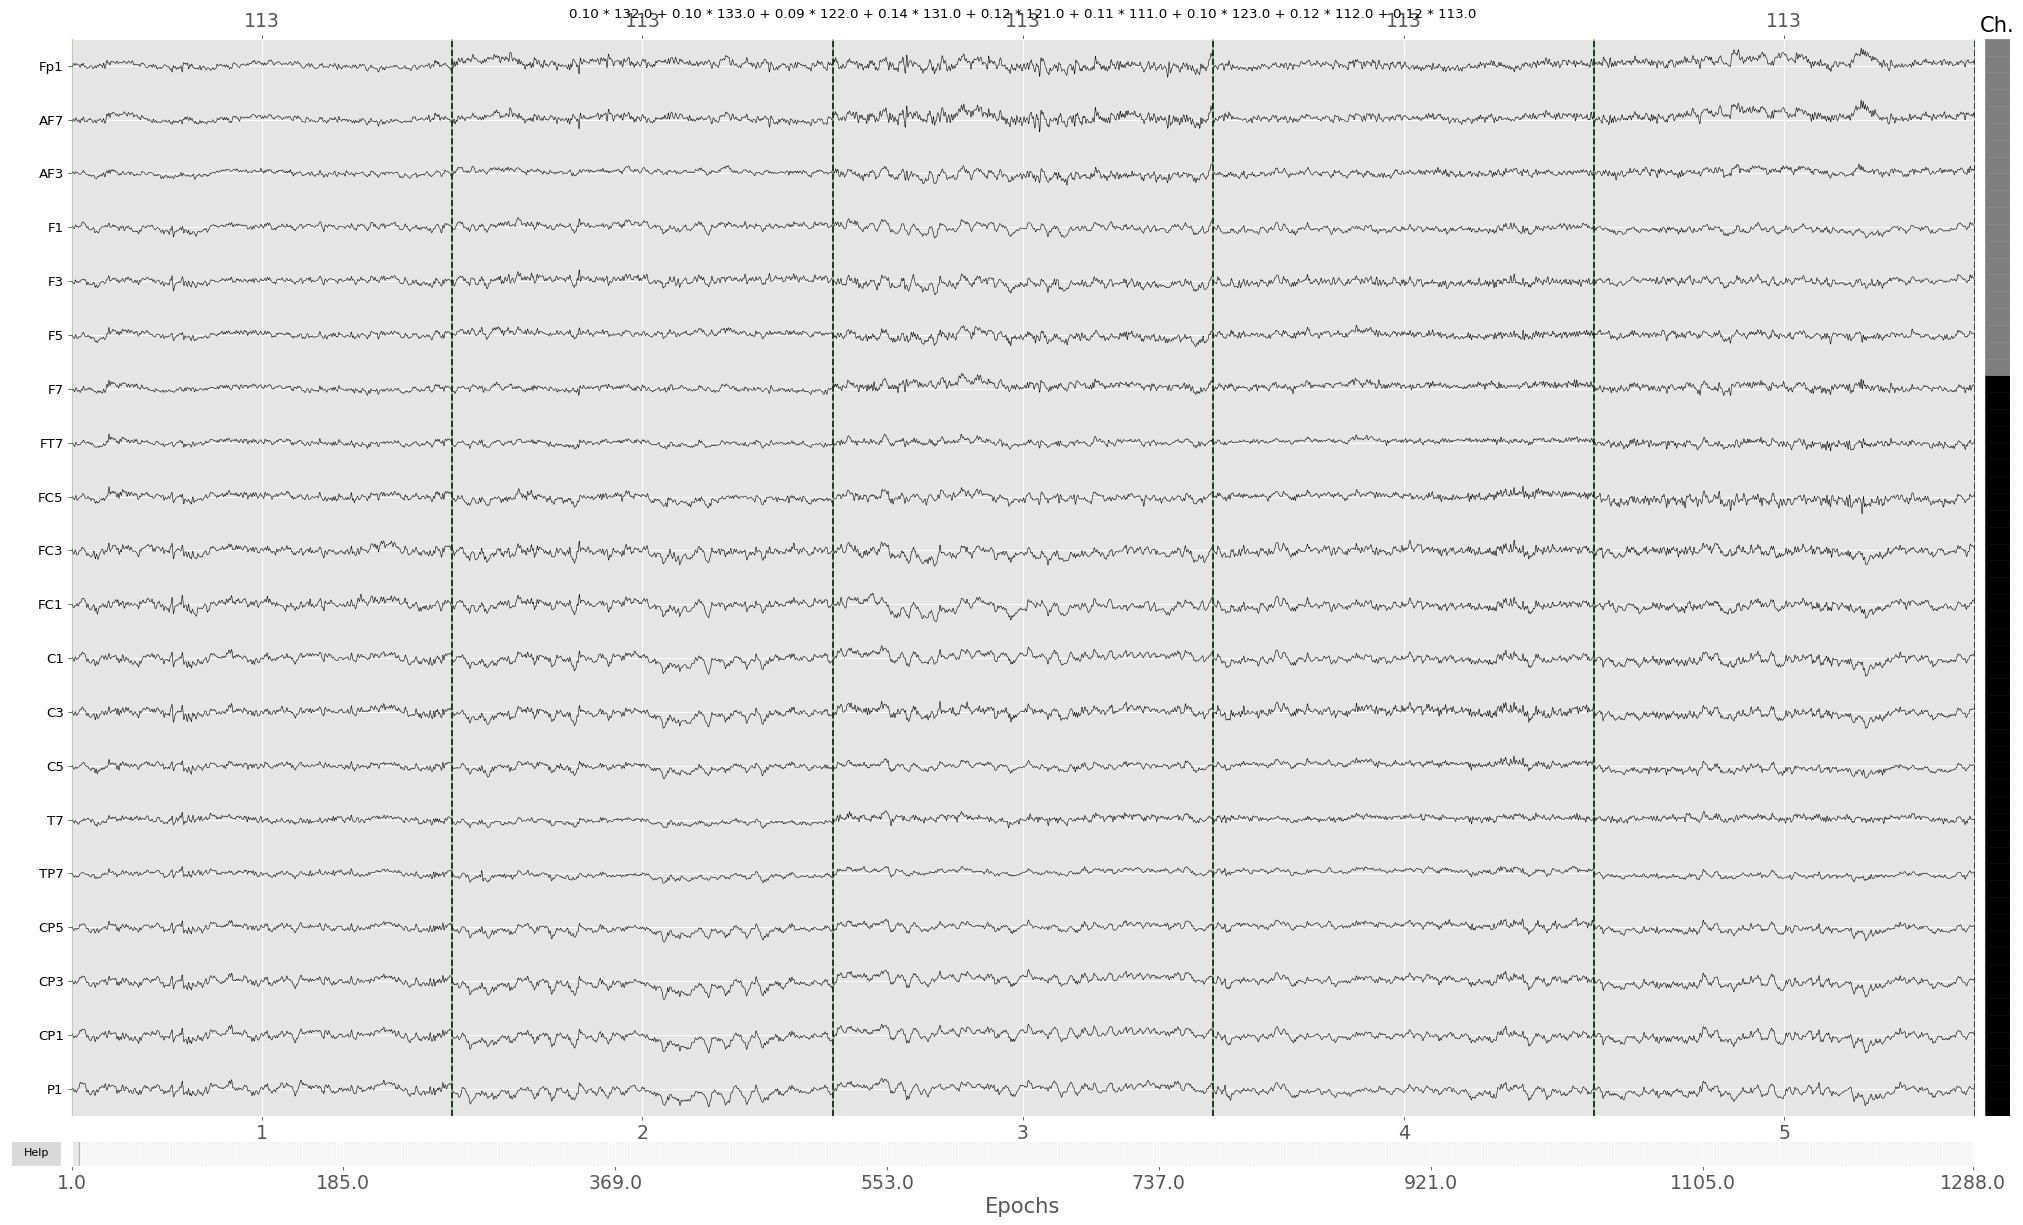

In [56]:
test_epochs=epochs_autorejected.copy()
mne.concatenate_epochs([test_epochs,test_epochs]).plot(scalings=100e-6,n_epochs=ochs=5)

# Below are personalised functions -> to py script and import

In [1]:
import warnings

def removeItem_from_dict(d,key):
    r = dict(d)
    del r[key]
    return r

def dict_getValue(dictionary, search_value):
    for key,value in dictionary.items():
        if value==search_value:
            return key

def mne_annotation_empty(annotations):
    index_dlt = 0
    for i in range(annotations.__len__()):
        annotations.delete(i-index_dlt)
        index_dlt+=1
    return annotations

def mne_annotation_postpone (pptime, annotations):
    onset = []
    duration = []
    description = []
    index_dlt = 0
    for i in range(annotations.__len__()):
        onset.append(annotations.__getitem__(i)['onset']+pptime)
        duration.append(0.0)
        description.append(annotations.__getitem__(i)['description'])
    for i in range(annotations.__len__()):
        annotations.delete(i-index_dlt)
        index_dlt+=1
    annotations.append(onset=onset,duration=duration,description=description)
    print ('annotation time shift succeed')
    
        

def mne_annotation_recode_by_adding(section,state,annotations):
    onset = []
    duration = []
    description = []
    for i in range(annotations.__len__()):
        if annotations.__getitem__(i)['description'] in ['131.0','132.0']:
            onset,duration,description = mne_annotation_recode_info_extract(section=section,state=state,
                                                                        original_annotation = 
                                                                        annotations.__getitem__(i),
                                                                       onset=onset,duration=duration,
                                                                        description=description)
        else:
            continue
    index_dlt = 0
    for i in range(annotations.__len__()):
        if annotations.__getitem__(i-index_dlt)['description'] in ['131.0','132.0']:
            annotations.delete(i-index_dlt)
            index_dlt+=1
        else:
            continue
    onset.append(0.0)
    duration.append(0.0)
    description.append(mne_annotation_add_baseline(section=section,state=state))
    annotations.append(onset=onset,duration=duration,description=description)
    print ('annotation engineering succeed')
    return True

def mne_annotation_add_baseline(section,state):
    if section == '1':
        if state == 'VD':
            return '113.0'
        elif state == 'FA':
            return '123.0'
        elif state == 'OP':
            return '133.0'
        else:
            warnings.warn("unknown state detected", DeprecationWarning)
    elif section == '2':
        if state == 'VD':
            return '213.0'
        elif state == 'FA':
            return '223.0'
        elif state == 'OP':
            return '233.0'
        else:
            warnings.warn("unknown state detected", DeprecationWarning)
    else:
        warnings.warn("add baseline function only apply on rawfile having 2 sections", DeprecationWarning)
    return '999.0'
        

def mne_annotation_recode_info_extract(section,state,original_annotation,onset,duration,description):
    if section =='1':
        if state == 'VD':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('111.0')
                
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('112.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'FA':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('121.0')

            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('122.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'OP':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('131.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('132.0')
            else:
                print('this function only detect VD, FA, OP states, please check original annotations')
    elif section =='2':
        if state == 'VD':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('211.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('212.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'FA':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('221.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('222.0')
            else:
                print('this function only detect safe and threat period, please check original annotations')
        elif state == 'OP':
            if original_annotation['description']=='131.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('231.0')
            elif original_annotation['description']=='132.0':
                onset.append(original_annotation['onset'])
                duration.append(original_annotation['duration'])
                description.append('123.0')
            else:
                print('this function only detect VD, FA, OP states, please check original annotations')
    else:
        print('3rd section dected, please check annotations')
    return(onset,duration,description)
        
